## I. MNIST Data

### Exercice 1 : Loading Data

In [52]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

1)Create a function iid_split. This function should take a dataset, nb_nodes, n_samples_per_node, batch_size, and shuffle as parameters. The goal is to divide the dataset into nb_nodes subsets (i.i.d.) and load each subset using PyTorch's DataLoader with the specified batch_size and shuffle, and then return a list of these DataLoaders.

Steps:
Load Data: Use DataLoader to load n_samples_per_node from the dataset with shuffle.  
Split Data: Divide the loaded data into nb_nodes i.i.d subsets, create a DataLoader for each, and append it to a list.   
Return List: Return the list of DataLoaders created.   

In [95]:
"""
1)Create a function iid_split. This function should take a dataset, nb_nodes, n_samples_per_node, batch_size, and shuffle as parameters. The goal is to divide the dataset into nb_nodes subsets (i.i.d.) and load each subset using PyTorch's DataLoader with the specified batch_size and shuffle, and then return a list of these DataLoaders.

Steps:
Load Data: Use DataLoader to load n_samples_per_node from the dataset with shuffle.  
Split Data: Divide the loaded data into nb_nodes i.i.d subsets, create a DataLoader for each, and append it to a list.   
Return List: Return the list of DataLoaders created.   
"""
def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle):
    # Load Data
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    # Split Data
    data = []
    for i in range(nb_nodes):
        data.append(torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, range(i*n_samples_per_node, (i+1)*n_samples_per_node)), batch_size=batch_size, shuffle=shuffle))
    # Return List
    return data

2) Create a function non_iid_split, designed to divide a dataset non-i.i.d. It will receive parameters: dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, and shuffle_digits.

Steps:
Arrange Digits: Optionally shuffle digits and fairly split them among nb_nodes.  
Load Data: Utilize DataLoader to load nb_nodes*n_samples_per_node samples, considering the shuffle parameter.   
Split Data and Return: Create DataLoaders for each node containing samples with corresponding digits and append them to a list.   

In [159]:
from torch.utils.data import DataLoader, Subset
"""
2) Create a function non_iid_split, designed to divide a dataset non-i.i.d. It will receive parameters: dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, and shuffle_digits.

Steps:
Arrange Digits: Optionally shuffle digits and fairly split them among nb_nodes.  
Load Data: Utilize DataLoader to load nb_nodes*n_samples_per_node samples, considering the shuffle parameter.   
Split Data and Return: Create DataLoaders for each node containing samples with corresponding digits and append them to a list.  
"""

def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits):
    
    digits = torch.arange(10) if not shuffle_digits else torch.randperm(
        10, generator=torch.Generator().manual_seed(0))

    digits_per_node = torch.split(digits, len(digits)//nb_nodes)

    data_splitted = list()
    for i, node_digits in enumerate(digits_per_node):
        indices = [idx for idx, (img, label) in enumerate(
            dataset) if label in node_digits.numpy()]

        if len(indices) < n_samples_per_node:
            raise ValueError(
                f"Not enough samples for node {i} with digits {node_digits}. Try reducing n_samples_per_node.")

        chosen_indices = np.random.choice(
            indices, n_samples_per_node, replace=False)

        subset = Subset(dataset, chosen_indices)
        dataloader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
        data_splitted.append(dataloader)

    return data_splitted


3) Create a function get_MNIST, that fetches the MNIST dataset and utilizes either iid_split or non_iid_split to return train and test DataLoaders. The parameters are type ("iid" or "non_iid"), n_samples_train, n_samples_test, n_clients, batch_size, and shuffle.

Steps:
Load MNIST Dataset: Utilize the MNIST dataset from PyTorch datasets for both train and test.  
Apply Split Function: Depending on the type parameter, apply either iid_split or non_iid_split to the loaded datasets.   
Return DataLoaders: Return the created train and test DataLoaders lists.  


In [118]:
import torchvision

"""
3) Create a function get_MNIST, that fetches the MNIST dataset and utilizes either iid_split or non_iid_split to return train and test DataLoaders. The parameters are type ("iid" or "non_iid"), n_samples_train, n_samples_test, n_clients, batch_size, and shuffle.

Steps:
Load MNIST Dataset: Utilize the MNIST dataset from PyTorch datasets for both train and test.  
Apply Split Function: Depending on the type parameter, apply either iid_split or non_iid_split to the loaded datasets.   
Return DataLoaders: Return the created train and test DataLoaders lists.  
"""
def get_MNIST(type, n_samples_train, n_samples_test, n_clients, batch_size, shuffle):
    # Load MNIST Dataset
    train_dataset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))]))
    test_dataset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5,), (0.5,))]))
    # Apply Split Function
    if type == "iid":
        train_data = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_data = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        train_data = non_iid_split(
            train_dataset, n_clients, n_samples_train, batch_size, shuffle, shuffle_digits=True)
        test_data = non_iid_split(
            test_dataset, n_clients, n_samples_test, batch_size, shuffle, shuffle_digits=True)
    # Return DataLoaders
    return train_data, test_data

4) Use get_MNIST to get mnist_iid_train and mnist_iid_test dataloaders.

In [98]:
# Use get_MNIST to get mnist_iid_train and mnist_iid_test dataloaders.
mnist_iid_train, mnist_iid_test = get_MNIST(
    type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)


5) Giving the following function plot_samples for iid data. Plot image samples of client 1, 2 and 3.

In [99]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):

    n_rows = int(n_examples / 5)
    plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title: plt.suptitle(title)
    X, y= data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")

    if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

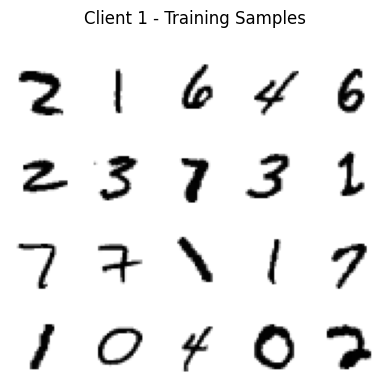

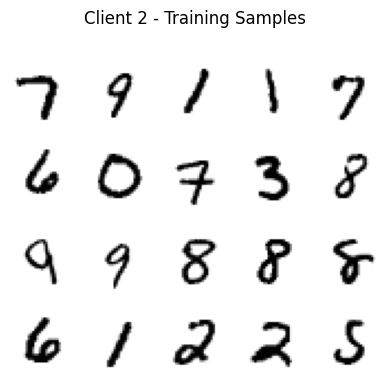

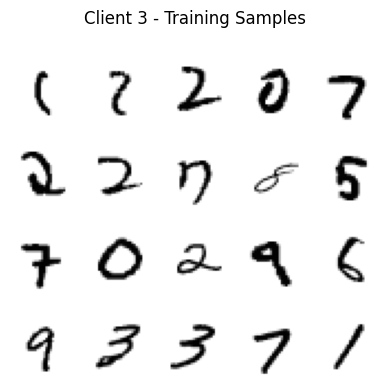

In [100]:
# Extract and plot image samples from the first DataLoader of client 1
data_client_1 = next(iter(mnist_iid_train[0]))
plot_samples(data_client_1, channel=0, title="Client 1 - Training Samples")

# Extract and plot image samples from the first DataLoader of client 2
data_client_2 = next(iter(mnist_iid_train[1]))
plot_samples(data_client_2, channel=0, title="Client 2 - Training Samples")

# Extract and plot image samples from the first DataLoader of client 3
data_client_3 = next(iter(mnist_iid_train[2]))
plot_samples(data_client_3, channel=0, title="Client 3 - Training Samples")

plt.show()

6) Plot samples this time for non_iid data for 3 clients.

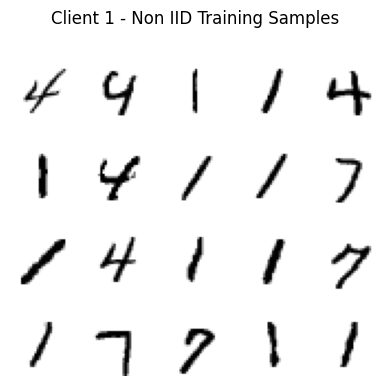

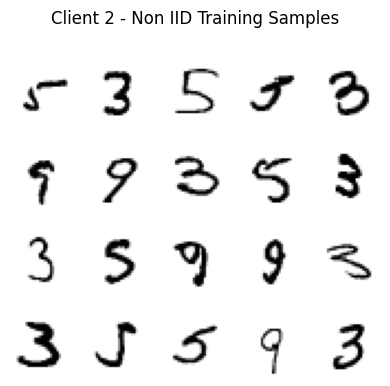

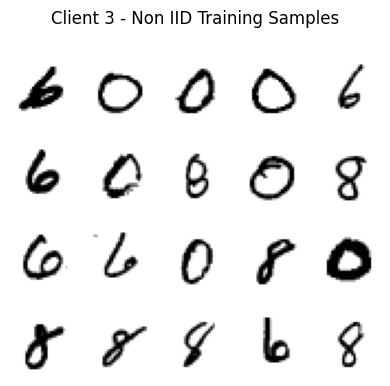

In [101]:
# Getting non_iid DataLoaders
mnist_non_iid_train, mnist_non_iid_test = get_MNIST(
    type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

# Extract and plot image samples from the first DataLoader of client 1
data_client_1_non_iid = next(iter(mnist_non_iid_train[0]))
plot_samples(data_client_1_non_iid, channel=0,
             title="Client 1 - Non IID Training Samples")

# Extract and plot image samples from the first DataLoader of client 2
data_client_2_non_iid = next(iter(mnist_non_iid_train[1]))
plot_samples(data_client_2_non_iid, channel=0,
             title="Client 2 - Non IID Training Samples")

# Extract and plot image samples from the first DataLoader of client 3
data_client_3_non_iid = next(iter(mnist_non_iid_train[2]))
plot_samples(data_client_3_non_iid, channel=0,
             title="Client 3 - Non IID Training Samples")

plt.show()

### Exercice 2 : FedAvg and FedProx Implementation

Here is a simple CNN.

In [102]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet ->
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_0 = CNN()

1) Create a function difference_models_norm_2(model_1, model_2) which take two models, get models parameters and returns the sum of the square differences of models parameters.





In [103]:
def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    diff = 0
    for param_1, param_2 in zip(model_1.parameters(), model_2.parameters()):
        diff += torch.norm(param_1 - param_2, p=2)
    return diff

Here is the function to perform one epoch of training data.

In [104]:
def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""

    total_loss=0

    for idx, (features,labels) in enumerate(train_data):

        optimizer.zero_grad()

        predictions= model(features)

        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss

        loss.backward()
        optimizer.step()

    return total_loss/(idx+1)

2) Create a function local_learning which perform a local training of a model sent. We need to precise number of epochs needed to be performed locally. Use previous function defined.

Return the local_loss compute during local training.

In [105]:
def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):

    ### Copy model to a new variable ###
    model_0 = deepcopy(model)

    for epoch in range(epochs):
        local_loss=train_step(model, model_0, mu, optimizer, train_data, loss_f)

    return float(local_loss.detach().numpy())

We defined 4 others usefull functions :
- loss_classifier :
- loss_dataset :
- accuracy_dataset :
- set_to_zero_model_weights :

Take time to read it.

In [106]:
def loss_classifier(predictions,labels):

    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")

    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0

    for idx,(features,labels) in enumerate(dataset):

        predictions= model(features)
        loss+=loss_f(predictions,labels)

    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""

    correct=0

    for features,labels in iter(dataset):

        predictions= model(features)

        _,predicted=predictions.max(1,keepdim=True)

        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()

    accuracy = 100*correct/len(dataset.dataset)

    return accuracy

def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)

3) Defined a function average_models, which as it is written average parameters of a list of models to create a new model.


In [107]:
def average_models(model, clients_models_hist:list , weights:list):


    """Creates the new model of a given iteration with the models of the other
    clients"""

    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):

        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)

    return new_model

4) We will now code a function to perform FedProx.

In [108]:
def FedProx(model, training_sets: list, n_iter: int, testing_sets: list, mu=0,
            file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """

    loss_f = loss_classifier

    # Variables initialization
    K = len(training_sets)  # number of clients
    n_samples = sum([len(db.dataset) for db in training_sets])
    weights = ([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:", weights)

    loss_hist = [[float(loss_dataset(model, dl, loss_f).detach())
                  for dl in training_sets]]
    acc_hist = [[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist = [[tens_param.detach().numpy()
                    for tens_param in list(model.parameters())]]
    models_hist = []

    server_loss = sum([weights[i]*loss_hist[-1][i]
                      for i in range(len(weights))])
    server_acc = sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')

    for i in range(n_iter):

        clients_params = []
        clients_models = []
        clients_losses = []

        for k in range(K):

            local_model = deepcopy(model)
            # Define optimizer for local_model, don't forget the learning rate !
            local_optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)

            # compute local_loss by performing learning steps on the current model
            local_loss = local_learning(
                local_model, mu, local_optimizer, training_sets[k], epochs, loss_f)

            clients_losses.append(local_loss)

            # GET THE PARAMETER TENSORS OF THE MODEL
            list_params = list(local_model.parameters())
            list_params = [tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)
            clients_models.append(deepcopy(local_model))

        # CREATE THE NEW GLOBAL MODEL
        # Create new global model by avering all locals models
        model = average_models(model, clients_params, weights)
        models_hist.append(clients_models)

        # COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist += [[float(loss_dataset(model, dl, loss_f).detach())
                       for dl in training_sets]]
        acc_hist += [[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss = sum([weights[i]*loss_hist[-1][i]
                          for i in range(len(weights))])
        server_acc = sum([weights[i]*acc_hist[-1][i]
                         for i in range(len(weights))])

        print(
            f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')

        server_hist.append([tens_param.detach().cpu().numpy()
                            for tens_param in list(model.parameters())])

        # DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr *= decay

    return model, loss_hist, acc_hist

###  Exercice 3 : iid data

#### Fed training with FedAvg

1) With FedProx compute a FedAvg on iid data.

In [109]:
# 1) With FedProx compute a FedAvg on iid data
model_0 = CNN()
model, loss_hist, acc_hist = FedProx(model_0, mnist_iid_train, n_iter=10,
    testing_sets=mnist_iid_test, mu=0, file_name="FedProx_iid", epochs=5,
    lr=10**-2, decay=1)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.311919689178467 Server Test Accuracy: 13.333333333333332


====> i: 1 Loss: 2.064800103505452 Server Test Accuracy: 51.0
====> i: 2 Loss: 1.3915534019470215 Server Test Accuracy: 70.33333333333333
====> i: 3 Loss: 0.6879602670669556 Server Test Accuracy: 77.33333333333333
====> i: 4 Loss: 0.440930038690567 Server Test Accuracy: 81.66666666666666
====> i: 5 Loss: 0.34020301699638367 Server Test Accuracy: 85.33333333333333
====> i: 6 Loss: 0.2909825245539347 Server Test Accuracy: 86.33333333333333
====> i: 7 Loss: 0.2289629926284154 Server Test Accuracy: 88.66666666666666
====> i: 8 Loss: 0.19511059423287708 Server Test Accuracy: 91.33333333333333
====> i: 9 Loss: 0.16908810039361316 Server Test Accuracy: 92.0
====> i: 10 Loss: 0.15279462933540344 Server Test Accuracy: 89.33333333333333


2) Define a function plot_accuracy_loss to plot accuracy and loss of performed FedAvg for the 3 different clients.

In [110]:
def plot_acc_loss(title:str, loss_hist:list, acc_hist:list):
    """
    Define a function plot_accuracy_loss to plot accuracy and loss of performed FedAvg for the 3 different clients.
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(loss_hist)
    plt.title(title+" Loss")
    plt.legend(["Client 1", "Client 2", "Client 3"])
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(acc_hist)
    plt.legend(["Client 1", "Client 2", "Client 3"])
    plt.title(title+" Accuracy")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.show()


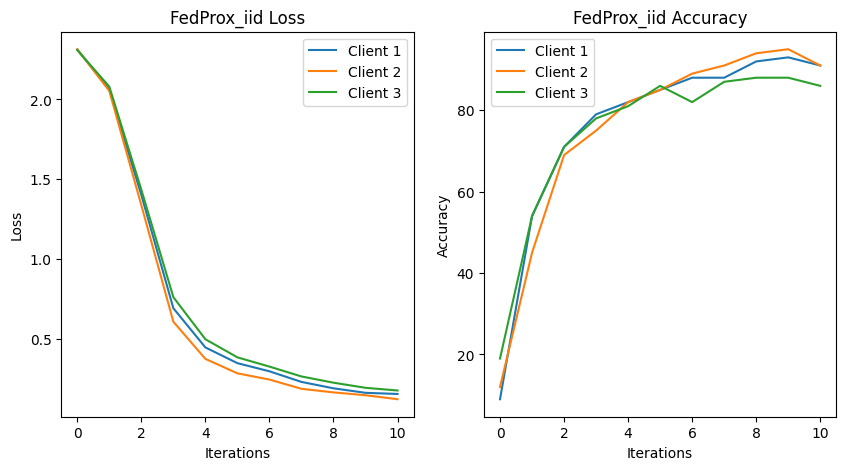

In [111]:
plot_acc_loss("FedProx_iid", loss_hist, acc_hist)

#### FedPRox

3) Do the same as for 1) and 2).
You can take 2 local epochs, a learning rate of 0.1, mu = 0.3 and 10 iterations.

In [112]:
global_model_prox = CNN()

final_model_prox, loss_hist_prox, acc_hist_prox = FedProx(
    global_model_prox, mnist_iid_train, 10,
    mnist_iid_test, mu=0.3, epochs=2, lr=0.1
)


Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3014323711395264 Server Test Accuracy: 11.666666666666666
====> i: 1 Loss: 1.5029395421346026 Server Test Accuracy: 60.99999999999999
====> i: 2 Loss: 0.9204435149828593 Server Test Accuracy: 70.66666666666666
====> i: 3 Loss: 0.46166313687960303 Server Test Accuracy: 77.33333333333333
====> i: 4 Loss: 0.24892647564411163 Server Test Accuracy: 88.66666666666666
====> i: 5 Loss: 0.2457984983921051 Server Test Accuracy: 88.66666666666666
====> i: 6 Loss: 0.15037811299165088 Server Test Accuracy: 92.33333333333333
====> i: 7 Loss: 0.1580747738480568 Server Test Accuracy: 90.66666666666666
====> i: 8 Loss: 0.11062650382518768 Server Test Accuracy: 91.0
====> i: 9 Loss: 0.09059919665257135 Server Test Accuracy: 92.33333333333333
====> i: 10 Loss: 0.07049039254585901 Server Test Accuracy: 94.0


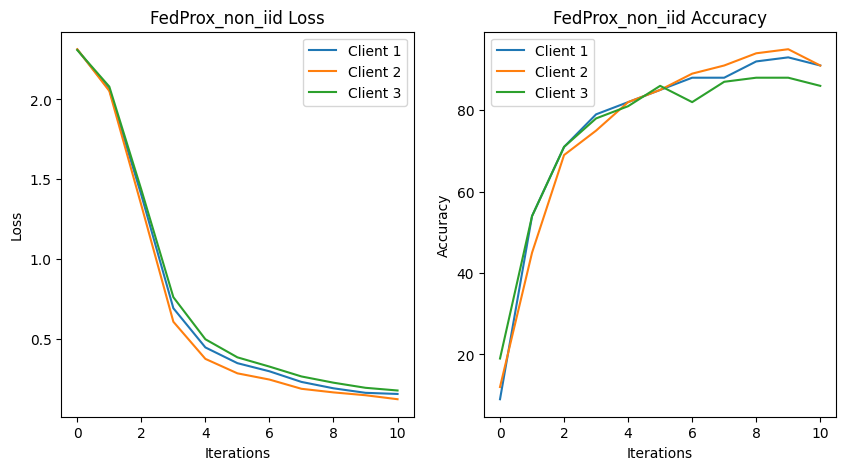

In [113]:
plot_acc_loss("FedProx_non_iid", loss_hist, acc_hist)


4) What do you observe ?

1. Convergence Rapide :
Tant FedAvg que FedProx présentent une convergence rapide vers une perte minimale, mais FedProx atteint plus rapidement des valeurs de perte plus faibles.

2. Amélioration de la Précision :
Les deux méthodes montrent une amélioration substantielle de la précision à chaque itération, avec FedProx atteignant légèrement une précision plus élevée vers la fin.

3. Variabilité des Clients :
On observe une variabilité notable de la perte et de la précision parmi les différents clients à chaque itération, qui tend à se stabiliser à mesure que le modèle converge.

4. Stabilité :
Après la convergence, la perte et la précision semblent relativement stables, avec de légères fluctuations dans les itérations ultérieures.

### Exercice 4 : Non iid data

1) Perform a FedAvg on data and plot accuracy and loss
2) Do the same for a FedProx.

In [119]:
"""
1) Perform a FedAvg on data and plot accuracy and loss
2) Do the same for a FedProx.
"""

mnist_non_iid_train, mnist_non_iid_test = get_MNIST(
    type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

In [127]:
global_model = CNN()

final_model_av, loss_hist_av, acc_hist_av = FedProx(
    global_model, mnist_non_iid_train, 10,
    mnist_non_iid_test, mu=0, epochs=5, lr=0.01, decay=1
)


Clients' weights: [0.25, 0.25, 0.25, 0.25]
====> i: 0 Loss: 2.311567723751068 Server Test Accuracy: 9.0
====> i: 1 Loss: 2.2338337302207947 Server Test Accuracy: 29.25
====> i: 2 Loss: 2.1354766488075256 Server Test Accuracy: 25.25
====> i: 3 Loss: 2.0400515496730804 Server Test Accuracy: 26.25
====> i: 4 Loss: 1.909129649400711 Server Test Accuracy: 35.75
====> i: 5 Loss: 1.7646732330322266 Server Test Accuracy: 51.0
====> i: 6 Loss: 1.587621957063675 Server Test Accuracy: 59.5
====> i: 7 Loss: 1.440916359424591 Server Test Accuracy: 65.5
====> i: 8 Loss: 1.3069058656692505 Server Test Accuracy: 67.5
====> i: 9 Loss: 1.1967359781265259 Server Test Accuracy: 66.25
====> i: 10 Loss: 1.1009099781513214 Server Test Accuracy: 72.0


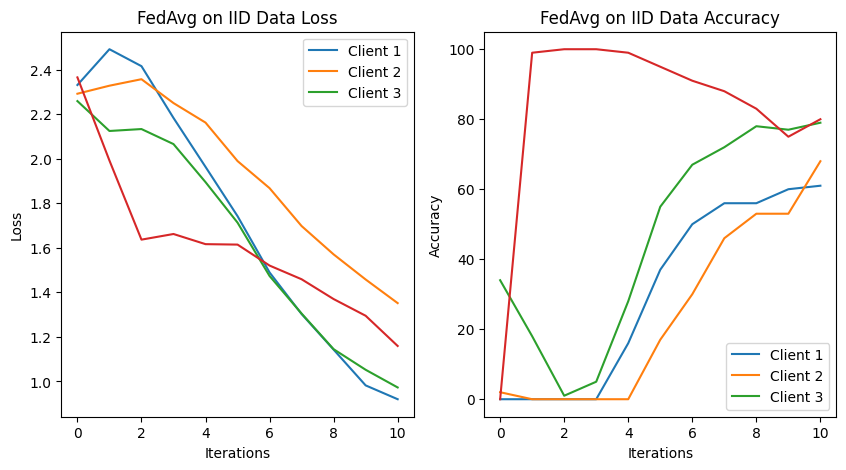

In [128]:
plot_acc_loss('FedAvg on IID Data', loss_hist_av, acc_hist_av)


In [129]:
# with mu=0.3

final_model_prox, loss_hist_prox, acc_hist_prox = FedProx(
    global_model, mnist_non_iid_train, 10,
    mnist_non_iid_test, mu=0.3, epochs=5, lr=0.01, decay=1
)

Clients' weights: [0.25, 0.25, 0.25, 0.25]
====> i: 0 Loss: 2.311567723751068 Server Test Accuracy: 9.0
====> i: 1 Loss: 2.244880497455597 Server Test Accuracy: 29.0
====> i: 2 Loss: 2.1585109531879425 Server Test Accuracy: 25.0
====> i: 3 Loss: 2.09340637922287 Server Test Accuracy: 26.25
====> i: 4 Loss: 2.0120110511779785 Server Test Accuracy: 29.75
====> i: 5 Loss: 1.912036806344986 Server Test Accuracy: 47.75
====> i: 6 Loss: 1.7930911481380463 Server Test Accuracy: 55.0
====> i: 7 Loss: 1.6635937690734863 Server Test Accuracy: 60.0
====> i: 8 Loss: 1.539025604724884 Server Test Accuracy: 63.75
====> i: 9 Loss: 1.4341014623641968 Server Test Accuracy: 64.5
====> i: 10 Loss: 1.3367591798305511 Server Test Accuracy: 64.0


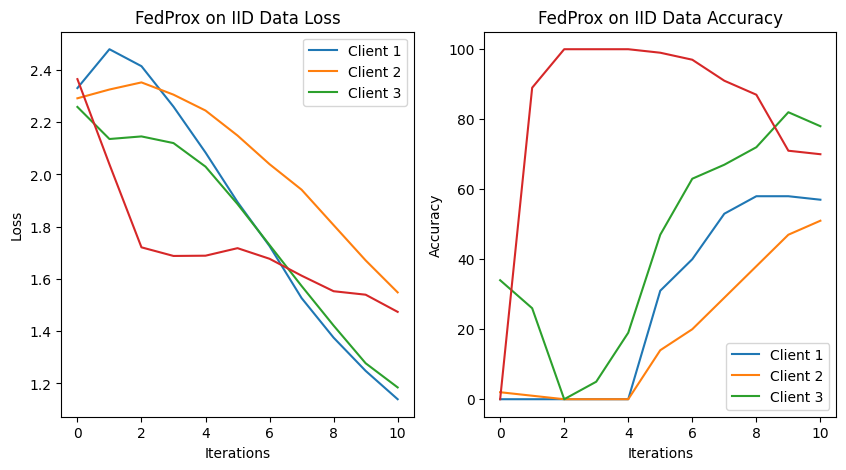

In [130]:
plot_acc_loss('FedProx on IID Data', loss_hist_prox, acc_hist_prox)


2) What do you observe ?

En observant les résultats pour à la fois FedAvg et FedProx, la perte diminue et la précision augmente au fil des itérations, ce qui est conforme aux attentes, car les modèles apprennent. Cependant, le processus d'apprentissage semble être plus difficile avec des données non-IDD, montrant un taux d'amélioration plus lent en termes de perte et de précision par rapport aux données IDD. Cela met en évidence le besoin de stratégies adaptatives dans les algorithmes d'apprentissage fédéré lorsqu'il s'agit de distributions de données non-IDD pour optimiser les résultats de l'apprentissage.

## II. Medical Data

### Exercice 5 : medmnist

For medical datasets we will use medmnist package.  
Medmnist is large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D : https://medmnist.com/

In [131]:
! pip install medmnist

  Obtaining dependency information for medmnist from https://files.pythonhosted.org/packages/79/dc/82309525ccddfd9b6d33f37b12579addaa735747378231265f7a7847a4cc/medmnist-2.2.3-py3-none-any.whl.metadata
  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/32/b2/1811645651153407f1e715b75afe9962d87582bee70b42c8671c255f8fe6/scikit_image-0.21.0-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/88.3 kB ? eta -:--:--
     ---------------------------------------- 88.3/88.3 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependency information for imageio>=2.27 from https://files.pythonhosted.org/packages/1a/55/7a7646d7cc42e771d689d39930afcbe57b3d82267544ebabead57ffb86d1/imageio-2.31.4-py3-none-any.whl.metadata
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/f5/72/68ea763b5f3e

Import medmnist

In [132]:
import medmnist

You can list all available datasets with this command

In [133]:
!python -m medmnist available

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist
	chestmnist
	dermamnist
	octmnist
	pneumoniamnist
	retinamnist
	breastmnist
	bloodmnist
	tissuemnist
	organamnist
	organcmnist
	organsmnist
	organmnist3d
	nodulemnist3d
	adrenalmnist3d
	fracturemnist3d
	vesselmnist3d
	synapsemnist3d


We will use BloodMNIST for the following exercices. BloodMnist is a dataset with 8 categories of blood cells capture by microscope.

1. Import from medmnsit BloodMNIST

In [134]:
from medmnist import BloodMNIST

In [135]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

2. Create a preprocessing pipeline for data, transforms it into Tensor and then normalize it with a mean of 0.5 and standard deviation of 0.5 also.

In [136]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

3. Create a train dataset and test dataset from data and apply previous preprocessing pipeline. You can use DataClass from pytorch to create datasets.

In [137]:
train_dataset = BloodMNIST(root='./data', split='train', transform=transform, download=True)
test_dataset = BloodMNIST(root='./data', split='test', transform=transform, download=True)


100%|██████████| 35461855/35461855 [00:06<00:00, 5221809.06it/s]


Using downloaded and verified file: ./data\bloodmnist.npz


4. Just to understand data print the 2 datasets to see differences with previous MNIST data.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


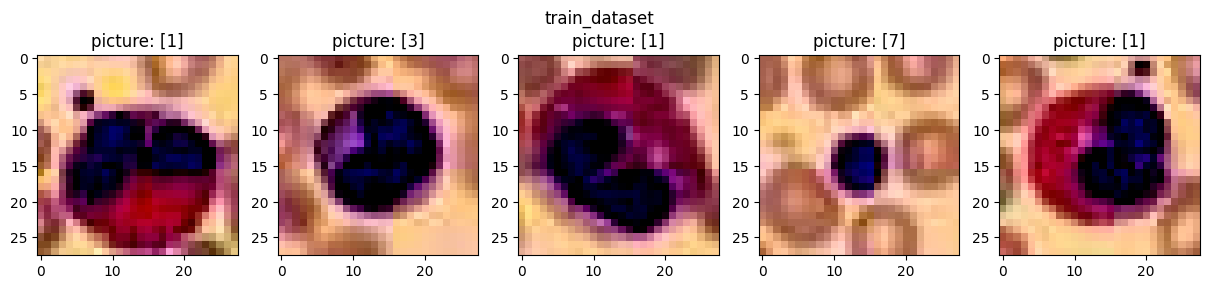

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


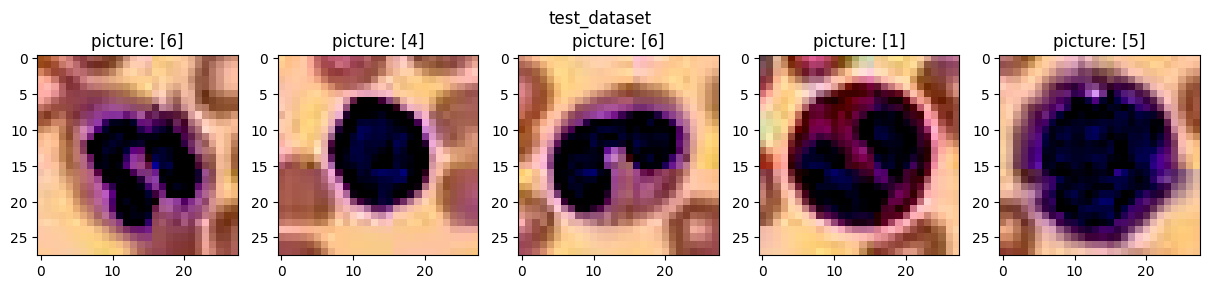

In [157]:
# 4. Just to understand data print the 2 datasets to see differences with previous MNIST data.
# show some images in the dataset

def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):
    
    _, axes = plt.subplots(1, 5, figsize=(15, 3))

    for ax in axes:
        i = np.random.randint(len(data))
        img, label = data[i]
        img = img.permute(1, 2, 0)
        ax.imshow(img, cmap='gray' if img.ndim == 2 else None)
        ax.set_title(f'picture: {label}')
    plt.suptitle(title)
    plt.show()


plot_samples(train_dataset, channel=0, title="train_dataset")
plot_samples(test_dataset, channel=0, title="test_dataset")


5. Create a data loader for train data and test dat, you can use a batch size of 128 and shuffle data.

In [149]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True)

6. Modify previous functions non_iid_split, iid_split, get_MNIST and plot_samples to work with new data.  
a. non_iid_split : this time there are only 8 classes   
b. iid_split : nothing really changed  
c. get_MNIST : Like in 3. use train and test datasets with the preprocessing pipeline we defined previously.  
d. plot_samples : Make it work for this new images. Also try to print to which classes belong every images, to see later if your iid_split and non_iid_split work well.

In [151]:
"""
6. Modify previous functions non_iid_split, iid_split, get_MNIST and plot_samples to work with new data.  
a. non_iid_split : this time there are only 8 classes   
b. iid_split : nothing really changed  
c. get_MNIST : Like in 3. use train and test datasets with the preprocessing pipeline we defined previously.  
d. plot_samples : Make it work for this new images. Also try to print to which classes belong every images, to see later if your iid_split and non_iid_split work well.
"""

def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits):
    assert (nb_nodes > 0 and nb_nodes <= 10)
    
    digits = torch.arange(8) if not shuffle_digits else torch.randperm(
        8, generator=torch.Generator().manual_seed(0))

    # split the digits in a fair way
    digits_per_node = torch.split(digits, len(digits)//nb_nodes)

    data_splitted = list()
    for i, node_digits in enumerate(digits_per_node):
        # Get indices for the digits, i.e., indices of elements in the dataset that have labels in node_digits
        indices = [idx for idx, (img, label) in enumerate(
            dataset) if label in node_digits.numpy()]

        # Check if we have enough samples
        if len(indices) < n_samples_per_node:
            raise ValueError(
                f"Not enough samples for node {i} with digits {node_digits}. Try reducing n_samples_per_node.")

        # Randomly choose n_samples_per_node from the available indices
        chosen_indices = np.random.choice(
            indices, n_samples_per_node, replace=False)

        # create a Subset and DataLoader object for each node and append it to data_splitted
        subset = Subset(dataset, chosen_indices)
        dataloader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)
        data_splitted.append(dataloader)

    # return data_splitted with all data loaders
    return data_splitted

def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle):
    # Load Data
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    # Split Data
    data = []
    for i in range(nb_nodes):
        data.append(torch.utils.data.DataLoader(torch.utils.data.Subset(dataset, range(i*n_samples_per_node, (i+1)*n_samples_per_node)), batch_size=batch_size, shuffle=shuffle))
    # Return List
    return data

def get_MNIST(type, n_samples_train, n_samples_test, n_clients, batch_size, shuffle):
    # Load MNIST Dataset
    train_dataset = BloodMNIST(root='./data', split='train', transform=transform, download=True)
    test_dataset = BloodMNIST(root='./data', split='test', transform=transform, download=True)
    # Apply Split Function
    if type == "iid":
        train_data = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_data = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        train_data = non_iid_split(
            train_dataset, n_clients, n_samples_train, batch_size, shuffle, shuffle_digits=True)
        test_data = non_iid_split(
            test_dataset, n_clients, n_samples_test, batch_size, shuffle, shuffle_digits=True)
    # Return DataLoaders
    return train_data, test_data

def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):
    
        n_rows = int(n_examples / 5)
        plt.figure(figsize=(1* n_rows, 1*n_rows))
        if title: plt.suptitle(title)
        X, y= data
        for idx in range(n_examples):
    
            ax = plt.subplot(n_rows, 5, idx + 1)
    
            image = 255 - X[idx, channel].view((28,28))
            ax.imshow(image, cmap='gist_gray')
            ax.axis("off")
    
        if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")
    
        plt.tight_layout()



### Exercice 6 : Use federated learning on medical data

### IID data

1. Load train data and test data for 3 clients into IID datasets.

In [152]:
# 1. Load train data and test data for 3 clients into IID datasets.

bloodmnist_iid_train, bloodmnist_iid_test = get_MNIST(
    type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

Using downloaded and verified file: ./data\bloodmnist.npz
Using downloaded and verified file: ./data\bloodmnist.npz


2. plost samples with corresponding function.

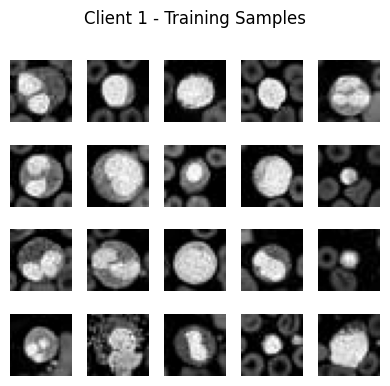

In [153]:
# 2. plost samples with corresponding function.

data_client_1 = next(iter(bloodmnist_iid_train[0]))
plot_samples(data_client_1, channel=0, title="Client 1 - Training Samples")

3. Design a convlution neural network to perform classification.  
You can try to adpat previous convolution network.   
Or also you can try this type of architecture :  
- A first 2D convolution layer with an output_channels of 16, a BatchNormalisation and a Relu activation   
- A second 2D conv layer identical but with a MaxPooling layer after  
- A 3rd conv layer with an output_channels of 64, a BatchNormalisation and a Relu activation again.
- A 4rd layer identical to 3rd one.  
- A 5rd layer identical but with a MaxPooling added. Don't forget to use padding to not loose informations from corners.
- Finally add dense layers to perform classification. You can add regularization layers between dropout for example.



In [154]:
"""
3. Design a convlution neural network to perform classification.  
You can try to adpat previous convolution network.   
Or also you can try this type of architecture :  
- A first 2D convolution layer with an output_channels of 16, a BatchNormalisation and a Relu activation   
- A second 2D conv layer identical but with a MaxPooling layer after  
- A 3rd conv layer with an output_channels of 64, a BatchNormalisation and a Relu activation again.
- A 4rd layer identical to 3rd one.  
- A 5rd layer identical but with a MaxPooling added. Don't forget to use padding to not loose informations from corners.
- Finally add dense layers to perform classification. You can add regularization layers between dropout for example.
"""

class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet ->
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 16, 3, 1)
        self.conv3 = nn.Conv2d(16, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3, 1)
        self.fc1 = nn.Linear(4*4*64, 500)
        self.fc2 = nn.Linear(500, 8)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.batch_norm(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.batch_norm(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

### Fed training with FedAvg

4. Perform a FedAvg with same parameters as for MNIST datasets. Use 3 clients, etc. Try to run more iterations.

In [156]:
# 4. Perform a FedAvg with same parameters as for MNIST datasets. Use 3 clients, etc. Try to run more iterations.

model_0 = CNN()

model, loss_hist, acc_hist = FedProx(model_0, bloodmnist_iid_train, n_iter=10,
    testing_sets=bloodmnist_iid_test, mu=0, file_name="FedProx_iid", epochs=5,
    lr=10**-2, decay=1)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


TypeError: batch_norm() missing 2 required positional arguments: 'running_mean' and 'running_var'

### FedPRox

5. As FedAvg perform a FedProx on iid data. Keep the same µ.

### MNIST Non iid

6. Do the same process (FedAVG, FedProx, plot loss and accuracy) but this time on non iid data.

7. Is results satisfying ? Submit some way to improve results and resolve possible unstabilities. For this you can check original paper : https://arxiv.org/pdf/1812.06127.pdf